# Bibliotécas

In [1]:
import pandas                                       as pd
import numpy                                        as np
import seaborn                                      as sns
import scikitplot                                   as skplt
from matplotlib              import pyplot          as plt
from scipy                   import stats           as ss
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import neighbors       as nh
from sklearn                 import linear_model    as lm
from matplotlib.gridspec     import GridSpec
from tabulate                import tabulate
from decimal                 import Decimal
from sklearn.ensemble        import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.display         import Image
import pickle
import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi_quadrado = ss.chi2_contingency(cm)[0]
    chi_quadrado_correcao = max(0, chi_quadrado - (k - 1) * (r -1) / (n -1))
    k_correcao = k - (k - 1) ** 2 / (n - 1)
    r_correcao = r - (r - 1) ** 2 / (n - 1)
    
    v = np.sqrt((chi_quadrado_correcao / n) / (min(k_correcao - 1, r_correcao -1)))
    return v

def precision_at_k(data, k = 2000):
    #Resetando o index
    data = data.reset_index()

    #Criando a ordem do rank
    data['Rank'] = data.index + 1 #Para não começar o zero e sim do número um
    
    #Inserindo a soma acumulada das linhas
    data['Precision_at_k'] = data['Response'].cumsum() / data['Rank']
    
    return data.loc[k, 'Precision_at_k']

def recall_at_k(data, k = 2000):
    #Resetando o index
    data = data.reset_index()

    #Criando a ordem do rank
    data['Rank'] = data.index + 1 #Para não começar o zero e sim do número um
   
    #Inserindo a soma acumulada das linhas
    data['Recall_at_k'] = data['Response'].cumsum() / data['Response'].sum()
    
    return data.loc[k, 'Recall_at_k']

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.1 Carregando os dados

In [3]:
df_treino_raw = pd.read_csv('dataset/train.csv')
df_teste_raw = pd.read_csv('dataset/test.csv')

df1 = df_treino_raw.copy()

### 1.2 Dimensão dos dados

In [4]:
df1.shape, df_teste_raw.shape

((381109, 12), (127037, 11))

### <s>1.2 Renomear as colunas</s>

### 1.3 Tipo de dados

In [5]:
df1.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

### 1.4 Verificar NA's

In [6]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### 1.5 Descrição estatística do negócio

#### 1.5.1 Descrição das colunas

**ID** -> ID exclusivo do cliente

**Gender** -> Gênero do cliente

**Age** -> Idade do cliente

**Driving_License** -> 0: O cliente não possui DL, 1: O cliente já possui DL

**Region_Code** -> Código exclusivo para a região do cliente

**Previously_Insured** -> 1: Cliente já possui Seguro Automóvel, 0: Cliente não possui Seguro Automóvel

**Vehicle_Age** -> Idade do Veículo

**Vehicle_Damage** -> 1: O cliente teve seu veículo danificado no passado. 0: O cliente não teve seu veículo danificado no passado

**Annual_Premium** -> O valor que o cliente precisa pagar como prêmio no ano

**Policy_Sales_Channel** -> Código anonimizado para o canal de divulgação ao cliente, ou seja. Diferentes agentes, por correio, por telefone, pessoalmente, etc

**Vintage** -> Número de dias em que o cliente esteve associado à empresa

**Response** -> 1: O cliente está interessado, 0: O cliente não está interessado

In [7]:
#Separando as colunas com variáveis numéricas e variáveis categóricas
atributos_numericos = df1.select_dtypes(include = ['int64', 'float64'])
atributos_categoricos = df1.select_dtypes(exclude = ['int64', 'float64'])

In [8]:
#Métricas de tendência central (média e mediana)
#Métricas de dispersão (desvio padrão, min, máx, amplitude, assimetria, curtose)

#### 1.5.2 Atributos numéricos

In [9]:
#Métricas de tendência central: média e mediana
central_1 = pd.DataFrame(atributos_numericos.apply(np.mean)).T
central_2 = pd.DataFrame(atributos_numericos.apply(np.median)).T

#Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
dispersao_1 = pd.DataFrame(atributos_numericos.apply(np.std)).T
dispersao_2 = pd.DataFrame(atributos_numericos.apply(np.min)).T
dispersao_3 = pd.DataFrame(atributos_numericos.apply(np.max)).T
dispersao_4 = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T
dispersao_5 = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T
dispersao_6 = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T

metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
metricas

,min,max,amplitude,mean,median,std,assimetria,kurtosis
id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
Age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
Driving_License,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
Region_Code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
Previously_Insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
Annual_Premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
Policy_Sales_Channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
Vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
Response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


#### 1.5.3 Atributos categóricos

In [10]:
#Encontrando a qtdes de tipos de categorias existem em cada coluna categórica
atributos_categoricos.apply(lambda x: x.unique().shape[0])

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

# 2. (Limpeza dos dados) Passo 2: Engenharia de atributos

In [11]:
df2 = df1.copy()

### 2.1 Derivando as variáveis a partir das variáveis originais

In [12]:
#Dados de treino
#Alterando os dados da coluna 'Vehicle_Age' e 'Vehicle_Damage'
df2['Vehicle_Age'] = df2['Vehicle_Age'].apply(
    lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
df2['Vehicle_Damage'] = df2['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

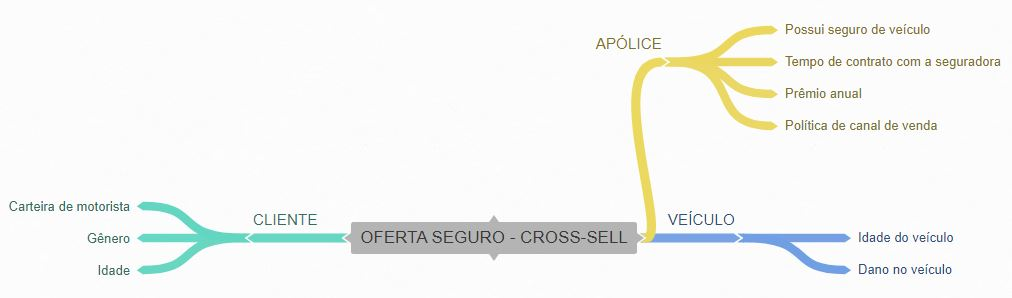

In [13]:
Image('Mapa_mental.JPG')

### 2.2 Mapa mental de hipóteses

#### 2.2.1 Criação de hipóteses

##### Hipótese Cliente
**1** Clientes que tem carteira de motorista teriam mais interesse em contratar um seguro de veículo?

**2** Clientes que tem gênero masculino teriam mais interesse em contratar um seguro de veículo?

**3** Clientes que tem idade menor de 40 anos teriam mais interesse em contratar um seguro de veículo?

##### Hipótese Apólice
**1** Clientes que já possuiam seguro anteriormente teriam mais interesse em contratar um novo seguro de veículo?

**2** Clientes que possuem contrato com a seguradora à mais tempo teriam mais interesse em contratar um seguro de veículo?

**3** Clientes que já pagaram prêmios anuais maiores teriam mais interesse em contratar um seguro de veículo?

**4** Clientes que receberam o anúncio por mais tipos de canais de venda teriam mais interesse em contratar um seguro de veículo?

##### Hipótese Veículo
**1** Clientes que tem veículos mais novos teriam mais interesse em contratar um seguro de veículo?

**2** Clientes que tem já tiveram seus veículos danificados teriam mais interesse em contratar um seguro de veículo?

#### 2.2.2 Priorizar as hipóteses

In [14]:
#Das hipóteses listadas, quais já são possiveis validar ou refutar com os dados disponives no dataset atual?

##### Hipótese Cliente
**1** Clientes que tem carteira de motorista teriam mais interesse em contratar um seguro de veículo?

**2** Clientes que tem gênero masculino teriam mais interesse em contratar um seguro de veículo?

**3** Clientes que tem idade menor de 40 anos teriam mais interesse em contratar um seguro de veículo?

##### Hipótese Apólice
**4** Clientes que já possuiam seguro anteriormente teriam mais interesse em contratar um novo seguro de veículo?

**5** Clientes que possuem contrato com a seguradora à mais tempo teriam mais interesse em contratar um seguro de veículo?

**6** Clientes que já pagaram prêmios anuais maiores teriam mais interesse em contratar um seguro de veículo?

**7** Clientes que receberam o anúncio por mais tipos de canais de venda teriam mais interesse em contratar um seguro de veículo?

##### Hipótese Veículo
**8** Clientes que tem veículos mais novos teriam mais interesse em contratar um seguro de veículo?

**9** Clientes que tem já tiveram seus veículos danificados teriam mais interesse em contratar um seguro de veículo?

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)

In [15]:
df3 = df2.copy()

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados

In [16]:
df4 = df3.copy()

In [17]:
#Em problemas de classificação, estamos buscando variáveis que tem uma separação natural para ajudar o modelo,
#ou seja, o modelo quer encontrar um hiperplano separador, ou melhor, um corte no espaço que consiga separar
#as 2 classes, se existirem variáveis que misturem estas 2 classes, são variáveis ruins, pois elas estariam
#confundindo o modelo ao invés de ajudá-lo. Uma boa técnica que pode ajudar a identificar o quão separado
#estão as variáveis são analisar a diferença das médias, dos quartis, plotar uma distribuição e avaliar
#se as distribuições são sobrepostas ou não.
#Em problemas de regressão, as correlações são mais fortes neste tipo de problema enquanto que na classificação
#estou buscando variáveis que são separadas entre si. 

### 4.1 Análise univariada

#### 4.1.1 Variável resposta

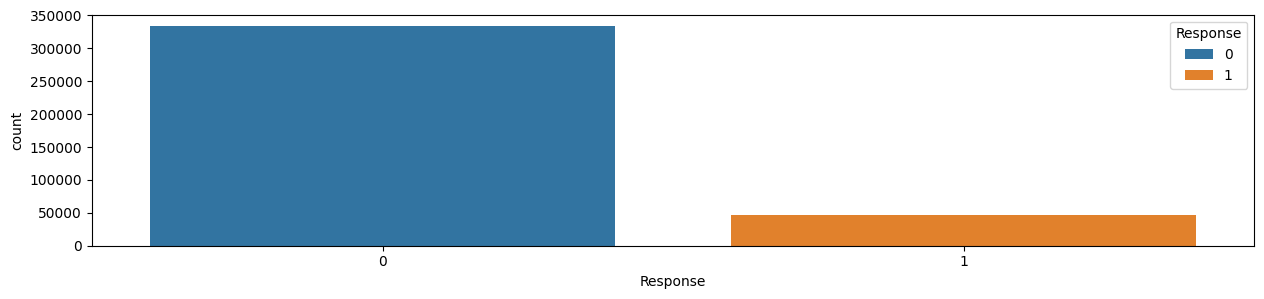

In [18]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#Response
#Os dados estão desbalanceados
sns.countplot(x = 'Response', hue = 'Response', data = df4);

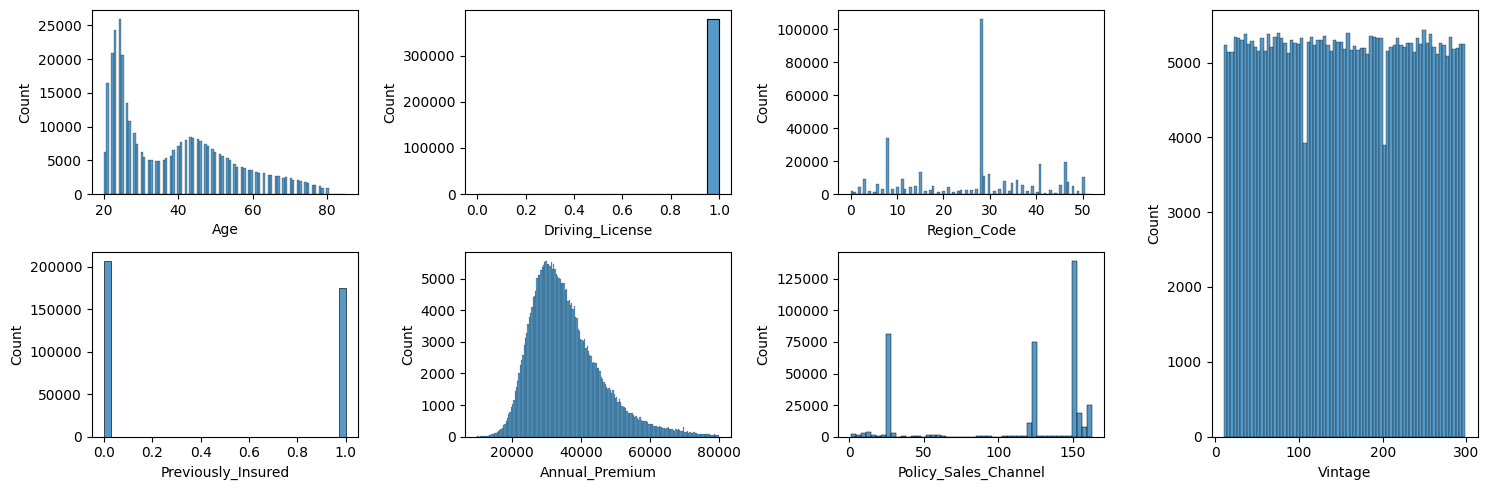

In [19]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#Age
plt.subplot(grid[0, 0])
sns.histplot(x = 'Age', data = atributos_numericos)

#Driving_License
plt.subplot(grid[0, 1])
sns.histplot(x = 'Driving_License', data = atributos_numericos)

#Region_Code
plt.subplot(grid[0, 2])
sns.histplot(x = 'Region_Code', data = atributos_numericos)

#Previously_Insured
plt.subplot(grid[1, 0])
sns.histplot(x = 'Previously_Insured', data = atributos_numericos)

#Annual_Premium
plt.subplot(grid[1, 1])
aux = atributos_numericos[(atributos_numericos['Annual_Premium'] > 10000) & (atributos_numericos['Annual_Premium'] < 80000)]
sns.histplot(x = 'Annual_Premium', data = aux)

#Policy_Sales_Channel
plt.subplot(grid[1, 2])
sns.histplot(x = 'Policy_Sales_Channel', data = atributos_numericos)

#Vintage
plt.subplot(grid[:, 3])
sns.histplot(x = 'Vintage', data = atributos_numericos)
plt.tight_layout();

### 4.2 Análise bivariada

#### 4.2.1 Variável numérica

**3** Clientes que tem idade menor de 40 anos teriam mais interesse em contratar um seguro de veículo?

**Verdadeira** Clientes que tem idade menor de 40 anos teriam SIM mais interesse em contratar um seguro de veículo

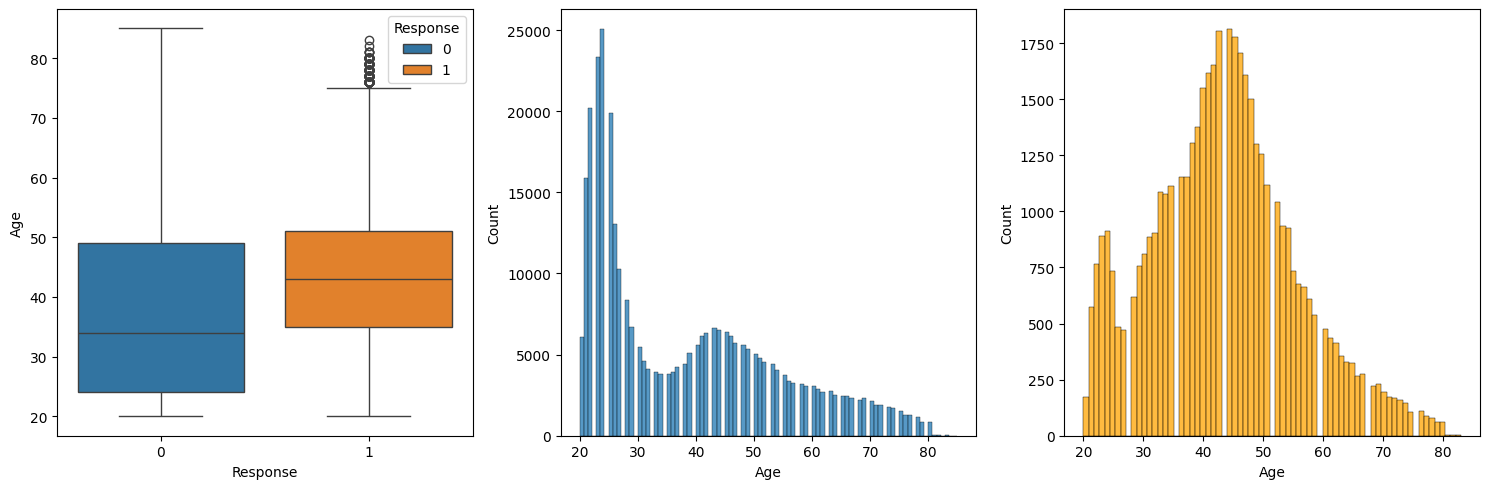

In [20]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

grid = GridSpec(1, 3) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#Age
#Tem uma variabilidade interessante, pois a mediana das pessoas que não querem seguro
#está mais baixa das pessoas que tem interesse em adquirir um seguro
plt.subplot(grid[0, 0])
sns.boxplot(x = 'Response', y = 'Age', hue = 'Response', data = df4)

plt.subplot(grid[0, 1])
aux1 = df4.loc[df4['Response'] == 0, 'Age']
sns.histplot(data = aux1)

plt.subplot(grid[0, 2])
aux2 = df4.loc[df4['Response'] == 1, 'Age']
sns.histplot(data = aux2, color = 'orange')
plt.tight_layout();

**6** Clientes que já pagaram prêmios anuais maiores teriam mais interesse em contratar um seguro de veículo?

**Verdadeira** Clientes que já pagaram prêmios anuais maiores teriam SIM mais interesse em contratar um seguro de veículo

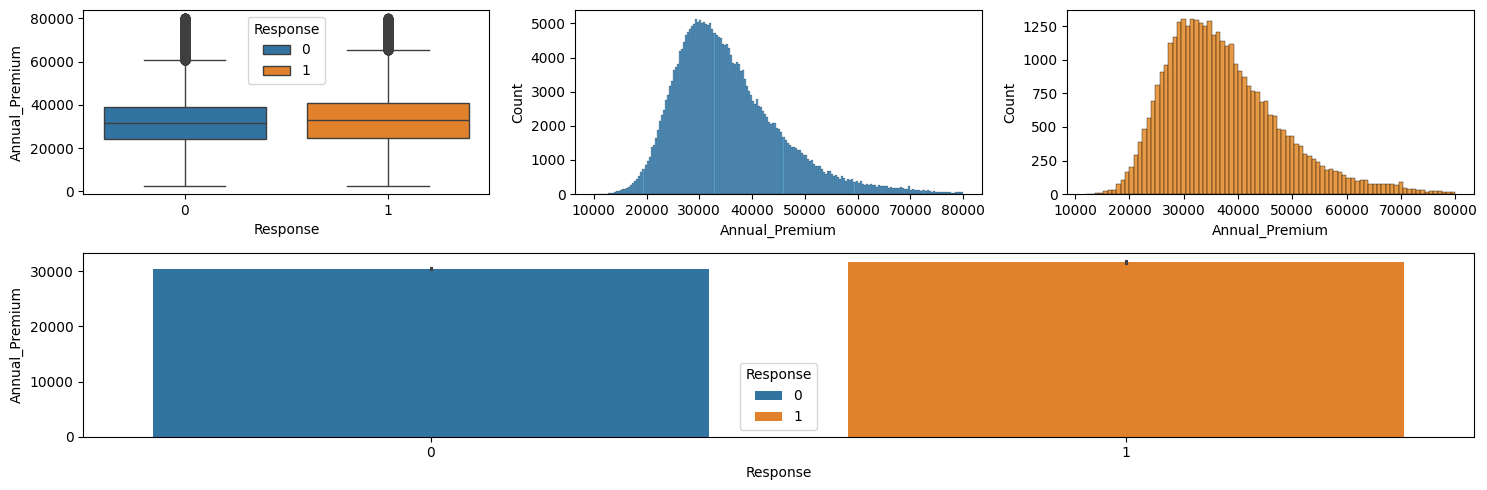

In [21]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

grid = GridSpec(2, 3) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#Annual_Premium
#Tem uma variabilidade ruim, pois a mediana do das pessoas que não querem seguro
#está muito parecida com o das pessoas que tem interesse em adquirir um seguro
#Como tem muito outliers, é melhor filtrar esta variável com valores menores
#para que possa observar a mediana e os quartis nos 2 boxplot
plt.subplot(grid[0, 0])
aux = df4[df4['Annual_Premium'] < 80000]
sns.boxplot(x = 'Response', y = 'Annual_Premium', hue = 'Response', data = aux)

plt.subplot(grid[0, 1])
aux = df4[(df4['Annual_Premium'] > 10000) & (df4['Annual_Premium'] < 80000)]
aux1 = aux.loc[aux['Response'] == 0, 'Annual_Premium']
sns.histplot(data = aux1)

plt.subplot(grid[0, 2])
aux = df4[(df4['Annual_Premium'] > 10000) & (df4['Annual_Premium'] < 80000)]
aux2 = aux.loc[aux['Response'] == 1, 'Annual_Premium']
sns.histplot(data = aux2, color = '#E07907')

plt.subplot(grid[1, :])
sns.barplot(x = 'Response', y = 'Annual_Premium', hue = 'Response', data = df4);
plt.tight_layout();

**1** Clientes que tem carteira de motorista teriam mais interesse em contratar um seguro de veículo?

**Falsa** Clientes que tem carteira de motorista NÃO teriam mais interesse em contratar um seguro de veículo

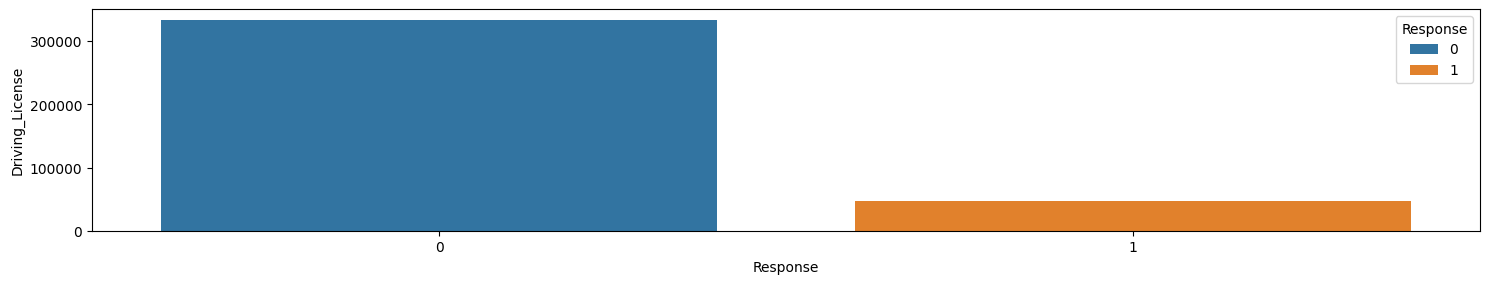

In [22]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#Driving_License
aux = df4[['Driving_License', 'Response']].groupby('Response').sum().reset_index()
sns.barplot(x = 'Response', y = 'Driving_License', hue = 'Response', data = aux)
plt.tight_layout();

In [23]:
#Driving_License
df4[['Driving_License', 'Response']].head()

,Driving_License,Response
0,1,1
1,1,0
2,1,1
3,1,0
4,1,0


In [24]:
aux['Driving_License_perc'] = aux['Driving_License'] / aux['Driving_License'].sum()
aux

,Response,Driving_License,Driving_License_perc
0,0,333628,0.877283
1,1,46669,0.122717


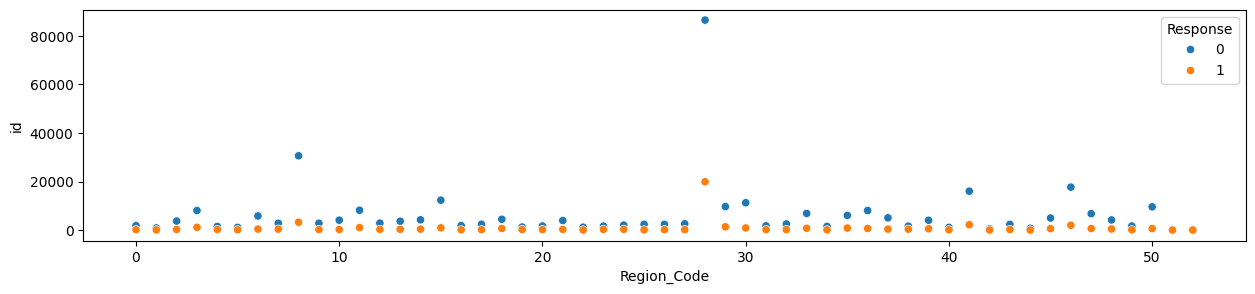

In [25]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#Region_Code
#Tentar verificar se existe algum conjunto ou grupo que teriam diferenças entres as classes, ou seja
#qual grupo pertence a uma classe e qual grupo pertence na outra classe
aux1 = df4[['id', 'Region_Code', 'Response']].groupby(['Region_Code', 'Response']).count().reset_index()
sns.scatterplot(x = 'Region_Code', y = 'id', hue = 'Response', data = aux1);

**4** Clientes que já possuiam seguro anteriormente teriam mais interesse em contratar um novo seguro de veículo?

**Falsa** Clientes que já possuiam seguro anteriormente NÃO teriam mais interesse em contratar um novo seguro de veículo

In [26]:
#Previously_Insured
#Este comando cruza 2 variáveis
pd.crosstab(df4['Previously_Insured'], df4['Response']).apply(lambda x: x / x.sum(), axis = 1)

Response,0,1
Previously_Insured,,
0,0.774546,0.225454
1,0.999095,0.000905


<s>**7** Clientes que receberam o anúncio por mais tipos de canais de venda teriam mais interesse em contratar um seguro de veículo?</s>

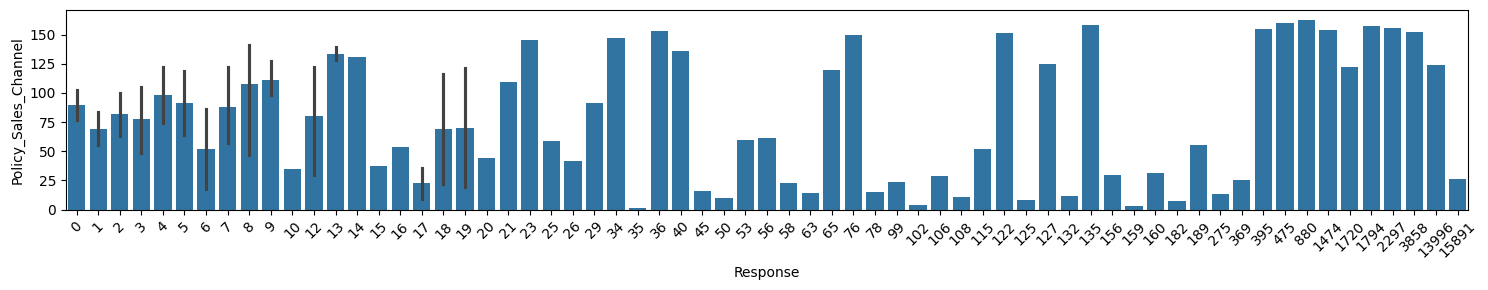

In [27]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#grid = GridSpec(2, 1) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#Policy_Sales_Channel
#plt.subplot(grid[0, 0])
aux = df4[['Policy_Sales_Channel', 'Response']].groupby(['Policy_Sales_Channel']).sum().reset_index()
sns.barplot(x = 'Response', y = 'Policy_Sales_Channel', data = aux)
plt.xticks(rotation = 45)
plt.tight_layout();

**5** Clientes que possuem contrato com a segurado à mais tempo teriam mais interesse em contratar um seguro de veículo?

**Falsa** Clientes que possuem contrato com a segurado à mais tempo NÃO teriam mais interesse em contratar um seguro de veículo

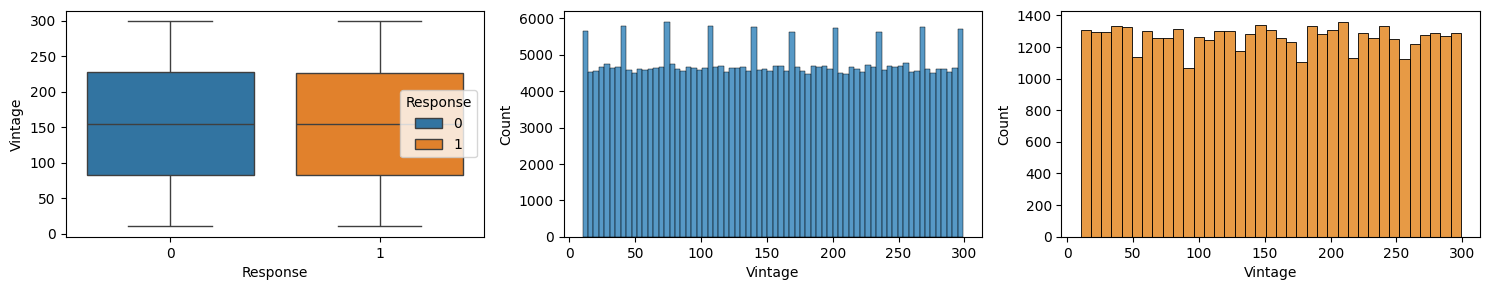

In [28]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

grid = GridSpec(1, 3) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#Vintage
#Tem uma variabilidade ruim, pois a mediana do das pessoas que não querem seguro
#está muito parecida (ou igual) com o das pessoas que tem interesse em adquirir um seguro
plt.subplot(grid[0, 0])
sns.boxplot(x = 'Response', y = 'Vintage', hue = 'Response', data = df4)

plt.subplot(grid[0, 1])
aux1 = df4.loc[df4['Response'] == 0, 'Vintage']
sns.histplot(data = aux1)

plt.subplot(grid[0, 2])
aux2 = df4.loc[df4['Response'] == 1, 'Vintage']
sns.histplot(data = aux2, color='#E07907')
plt.tight_layout();

#### 4.2.2 Variável categórica

**2** Clientes que tem gênero masculino teriam mais interesse em contratar um seguro de veículo?

**Verdadeira** Clientes que tem gênero masculino teriam SIM mais interesse em contratar um seguro de veículo

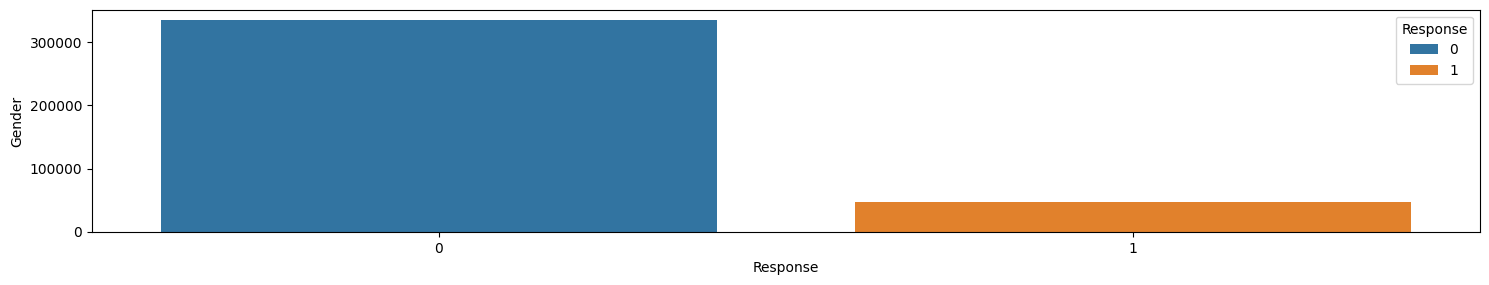

In [29]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#Gender
aux = df4[['Gender', 'Response']].groupby('Response').count().reset_index()
sns.barplot(x = 'Response', y = 'Gender', hue = 'Response', data = aux)
plt.tight_layout();

In [30]:
aux = df4[['Gender', 'Response']].value_counts(normalize = True).reset_index()
aux.sort_values('Gender')

,Gender,Response,proportion
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


**8** Clientes que tem veículos mais novos teriam mais interesse em contratar um seguro de veículo?

**Falsa** Clientes que tem veículos entre 1 e 2 anos teriam mais interesse em contratar um seguro de veículo

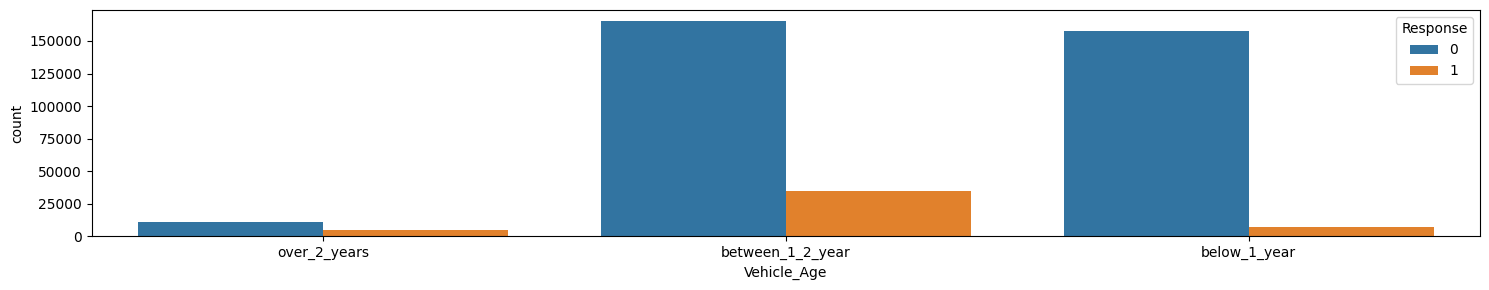

In [31]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#'Vehicle_Age'
sns.countplot(x = 'Vehicle_Age', hue = 'Response', data = df4)
plt.tight_layout();

In [32]:
#O 'Vehicle_Age' = over_2_years tem uma discriminação muito pequena entre as classes, já
#o 'Vehicle_Age' = below_1_year e between_1_2_year tem uma discriminação bem maior entre as
#classes, ou seja, pode ser uma variável interessante
aux = df4[['Vehicle_Age', 'Response']].value_counts(normalize = True).reset_index()
aux.sort_values('Vehicle_Age')

,Vehicle_Age,Response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_year,0,0.434285
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


**9** Clientes que tem já tiveram seus veículos danificados teriam mais interesse em contratar um seguro de veículo?

**Falsa** Clientes que tem já tiveram seus veículos danificados NÃO teriam mais interesse em contratar um seguro de veículo

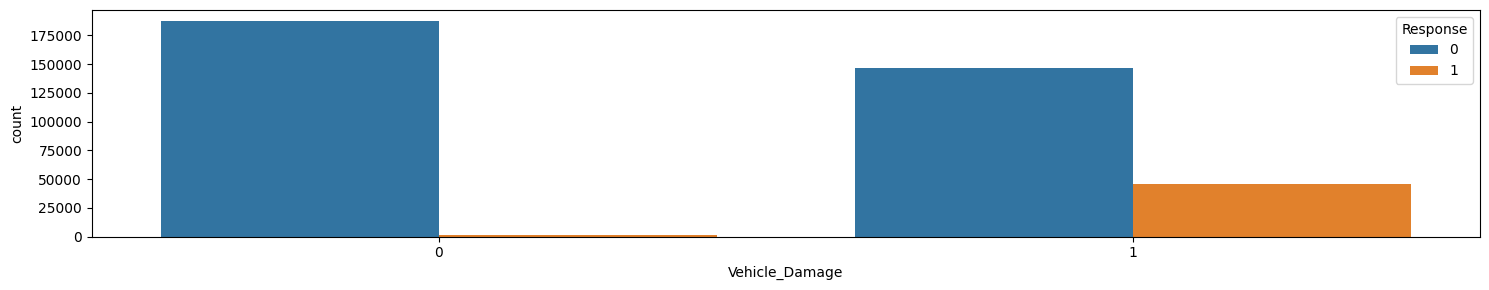

In [33]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

#'Vehicle_Damage'
sns.countplot(x = 'Vehicle_Damage', hue = 'Response', data = df4)
plt.tight_layout();

In [34]:
aux = df4[['Vehicle_Damage', 'Response']].value_counts(normalize = True).reset_index()
aux.sort_values('Vehicle_Damage')

,Vehicle_Damage,Response,proportion
0,0,0,0.492547
3,0,1,0.002577
1,1,0,0.384890
2,1,1,0.119987


### 4.3 Análise multivariada

#### 4.3.1 Variável numérica

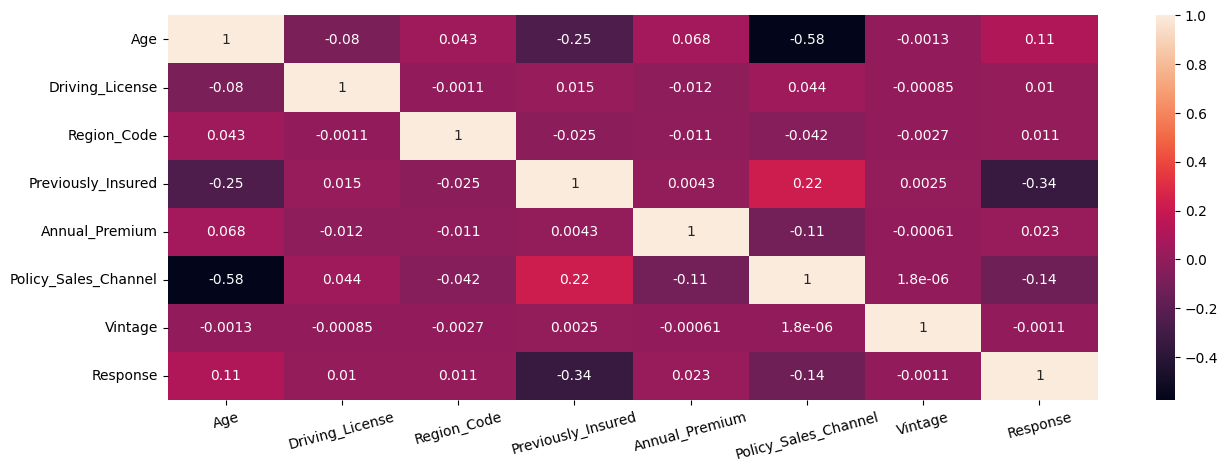

In [35]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

correlation = atributos_numericos.drop(['id'], axis = 1).corr(method = 'pearson')
sns.heatmap(correlation, annot = True)
plt.xticks(rotation = 15);

#### 4.3.2 Variável categórica

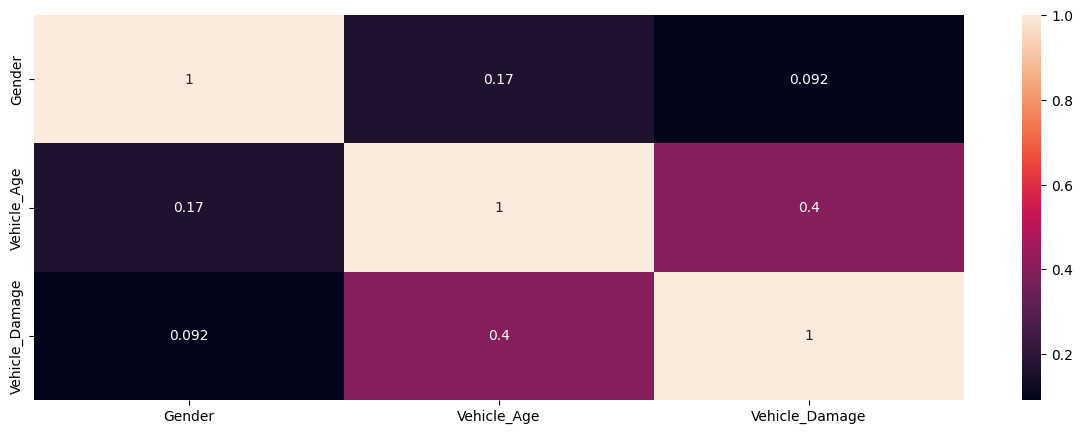

In [36]:
a = atributos_categoricos

a1 = cramer_v(a['Gender'], a['Gender'])
a2 = cramer_v(a['Gender'], a['Vehicle_Age'])
a3 = cramer_v(a['Gender'], a['Vehicle_Damage'])

a4 = cramer_v(a['Vehicle_Age'], a['Gender'])
a5 = cramer_v(a['Vehicle_Age'], a['Vehicle_Age'])
a6 = cramer_v(a['Vehicle_Age'], a['Vehicle_Damage'])

a7 = cramer_v(a['Vehicle_Damage'], a['Gender'])
a8 = cramer_v(a['Vehicle_Damage'], a['Vehicle_Age'])
a9 = cramer_v(a['Vehicle_Damage'], a['Vehicle_Damage'])

pd.DataFrame({'Gender': [a1, a2, a3],
              'Vehicle_Age': [a4, a5, a6],
              'Vehicle_Damage': [a7, a8, a9]})

d = pd.DataFrame({'Gender': [a1, a2, a3],
                  'Vehicle_Age': [a4, a5, a6],
                  'Vehicle_Damage': [a7, a8, a9]})
d = d.set_index(d.columns) #Inserindo os nomes das linhas iguais aos nomes das colunas

plt.figure(figsize = (15, 5))
sns.heatmap(d, annot = True);

### 4.4 Resumo das variáveis

In [37]:
tab = [['Variavel', 'Conclusao', 'Relevancia'],
      ['Age', 'Verdadeira', 'Boa'],
      ['Annual_Premium', 'Verdadeira', 'Ruim'],
      ['Driving_License', 'Falsa', 'Boa'],
      ['Previously_Insured', 'Falsa', 'Boa'],
      ['Vehicle_Age', 'Falsa', 'Média'],
      ['Policy_Sales_Channel', '-', 'Ruim'],
      ['Vintage', 'Falsa', 'Ruim'],
      ['Gender', 'Verdadeira', 'Boa'],
      ['Vehicle_Damage', 'Falsa', 'Boa']]
print(tabulate(tab, headers = 'firstrow'))

Variavel              Conclusao    Relevancia
--------------------  -----------  ------------
Age                   Verdadeira   Boa
Annual_Premium        Verdadeira   Ruim
Driving_License       Falsa        Boa
Previously_Insured    Falsa        Boa
Vehicle_Age           Falsa        Média
Policy_Sales_Channel  -            Ruim
Vintage               Falsa        Ruim
Gender                Verdadeira   Boa
Vehicle_Damage        Falsa        Boa


# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [38]:
df5 = df4.copy()

### 5.1 Separar os dados em treino e validação

In [39]:
x = df5.drop('Response', axis = 1)
y = df5['Response'].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2)

df5 = pd.concat([x_treino, y_treino], axis = 1)

In [40]:
print('x_treino: {}'.format(x_treino.shape))
print('x_teste: {}'.format(x_teste.shape))
print('y_treino: {}'.format(y_treino.shape))
print('y_teste: {}'.format(y_teste.shape))

x_treino: (304887, 11)
x_teste: (76222, 11)
y_treino: (304887,)
y_teste: (76222,)


### 5.2 Variável numérica

#### 5.2.1 Padronização

In [41]:
#Este tipo de transformação de variáveis são indicadas para distribuições normais
#Verificar na análise univariada quais variáveis tem esta caracteristica de distribuição normal

In [42]:
ss = pp.StandardScaler()

#Annual_Premium
df5['Annual_Premium'] = ss.fit_transform(df5[['Annual_Premium']].values) #Precisa passar um array

#Salvando a transformação em Pickle
pickle.dump(ss, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Annual_Premium_scaler.pkl', 'wb'))

#### 5.2.2 Normalização

In [43]:
#Este tipo de transformação de variáveis são indicadas para distribuições não normais

In [44]:
#Age
mms_age = pp.MinMaxScaler()
df5['Age'] = mms_age.fit_transform(df5[['Age']].values) #Precisa passar um array

#Salvando a transformação em Pickle
pickle.dump(mms_age, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Age_scaler.pkl', 'wb'))

#Vintage
mms_vintage = pp.MinMaxScaler()
df5['Vintage'] = mms_vintage.fit_transform(df5[['Vintage']].values) #Precisa passar um array

#Salvando a transformação em Pickle
pickle.dump(mms_vintage, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Vintage_scaler.pkl', 'wb'))

### 5.3 Variável categórica

#### 5.3.1 Encoding

In [45]:
#Driving_License -> Já está "encodado" naturalmente
#Previously_Insured -> Já está "encodado" naturalmente
#Vehicle_Damage -> Já está "encodado" naturalmente

In [46]:
#Gender -> Target Encoding
#Target Encoding
target_encode_gender = df5.groupby('Gender')['Response'].mean()
df5.loc[:, 'Gender'] = df5['Gender'].map(target_encode_gender)

#Salvando a transformação em Pickle
pickle.dump(target_encode_gender, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Gender_scaler.pkl', 'wb'))

#Region_Code -> Target Encoding
#Target Encoding
target_encode_region_code = df5.groupby('Region_Code')['Response'].mean()
df5.loc[:, 'Region_Code'] = df5['Region_Code'].map(target_encode_region_code)

#Salvando a transformação em Pickle
pickle.dump(target_encode_region_code, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Region_Code_scaler.pkl', 'wb'))

#Vehicle_Age -> One Hot Encoding ou Ordinal Encoding
#One Hot Encoding
df5 = pd.get_dummies(df5, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

#Policy_Sales_Channel -> Target Encoding ou Frequency Encoding
#Frequency Encoding
frequency_policy_sales_channel = df5.groupby('Policy_Sales_Channel').size() / len(df5)
df5.loc[:, 'Policy_Sales_Channel'] = df5['Policy_Sales_Channel'].map(frequency_policy_sales_channel)

#Salvando a transformação em Pickle
pickle.dump(frequency_policy_sales_channel, open('/home/leonardo/projetos_/propensao_de_compra/API/transformacoes/Policy_Sales_Channel_scaler.pkl', 'wb'))

### 5.4 Preparação dos dados de validação

#### 5.4.1 Variável numérica

In [47]:
#Age
#x_validacao.loc[:, 'Age'] = mms_age.fit_transform(x_validacao[['Age']].values) #Precisa passar um array

#Vintage
#x_validacao.loc[:, 'Vintage'] = mms_vintage.fit_transform(x_validacao[['Vintage']].values) #Precisa passar um array

#Annual_Premium
#x_validacao.loc[:, 'Annual_Premium'] = ss.fit_transform(x_validacao[['Annual_Premium']].values) #Precisa passar um array

#### 5.4.2 Variável categórica

In [48]:
#Region_Code
#x_validacao.loc[:, 'Region_Code'] = x_validacao['Region_Code'].map(target_encode_region_code)

#Vehicle_Age
#x_validacao = pd.get_dummies(x_validacao, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

#Policy_Sales_Channel
#x_validacao.loc[:, 'Policy_Sales_Channel'] = x_validacao['Policy_Sales_Channel'].map(frequency_policy_sales_channel)

#Gender -> Target Encoding
#x_validacao.loc[:, 'Gender'] = x_validacao['Gender'].map(target_encode_gender)

#fillna
#x_validacao = x_validacao.fillna(0) 

### 5.5 Preparação dos dados de teste

#### 5.5.1 Variável numérica

In [49]:
#Age
x_teste.loc[:, 'Age'] = mms_age.fit_transform(x_teste[['Age']].values) #Precisa passar um array

#Vintage
x_teste.loc[:, 'Vintage'] = mms_vintage.fit_transform(x_teste[['Vintage']].values) #Precisa passar um array

#Annual_Premium
x_teste.loc[:, 'Annual_Premium'] = ss.fit_transform(x_teste[['Annual_Premium']].values) #Precisa passar um array

#### 5.5.2 Variável categórica

In [50]:
#Alterando os dados da coluna 'Vehicle_Age' e 'Vehicle_Damage'
x_teste['Vehicle_Age'] = x_teste['Vehicle_Age'].apply(
    lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
x_teste['Vehicle_Damage'] = x_teste['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

#Region_Code
x_teste.loc[:, 'Region_Code'] = x_teste['Region_Code'].map(target_encode_region_code)

#Vehicle_Age
x_teste = pd.get_dummies(x_teste, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

#Policy_Sales_Channel
x_teste.loc[:, 'Policy_Sales_Channel'] = x_teste['Policy_Sales_Channel'].map(frequency_policy_sales_channel)

#Gender -> Target Encoding
x_teste.loc[:, 'Gender'] = x_teste['Gender'].map(target_encode_gender)

#fillna
x_teste = x_teste.fillna(0) 

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [51]:
df6 = df5.copy()

### 6.1 Selecionar as variáveis mais relevantes

#### 6.1.1 Implementar o Boruta

In [52]:
#Instanciando o algoritmo de Random Forest
#rf = RandomForestRegressor(n_jobs = -1)

#Boruta espera receber um vetor e não dataframe
#boruta = BorutaPy(rf, n_estimators = 1, verbose = 2, random_state = 42).fit(df6.drop(['id', 'Response'], axis = 1).values, df6['Response'].values)

#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = df6.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

In [53]:
#Como o Boruta encontrou somente 1 variável, utilizaremos a importância das árvores para encontrar as melhores variáveis 

#### 6.1.2 Importância das árvores

In [54]:
#Definição do modelo
forest = ExtraTreesClassifier(n_estimators = 200, random_state = 0, n_jobs = -1)

#Preparação dos dados
x_treino_n = df6.drop(['id', 'Response'], axis = 1)
y_treino_n = y_treino.values
forest.fit(x_treino_n, y_treino_n)

ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=0)

Rank das importâncias:
                       Variavel  Importancia
0                       Vintage     0.271866
0                Annual_Premium     0.243964
0                           Age     0.165795
0                   Region_Code     0.106289
0                Vehicle_Damage     0.067875
0          Policy_Sales_Channel     0.060126
0            Previously_Insured     0.056059
0      Vehicle_Age_below_1_year     0.013989
0  Vehicle_Age_between_1_2_year     0.006523
0                        Gender     0.004785
0      Vehicle_Age_over_2_years     0.002250
0               Driving_License     0.000480


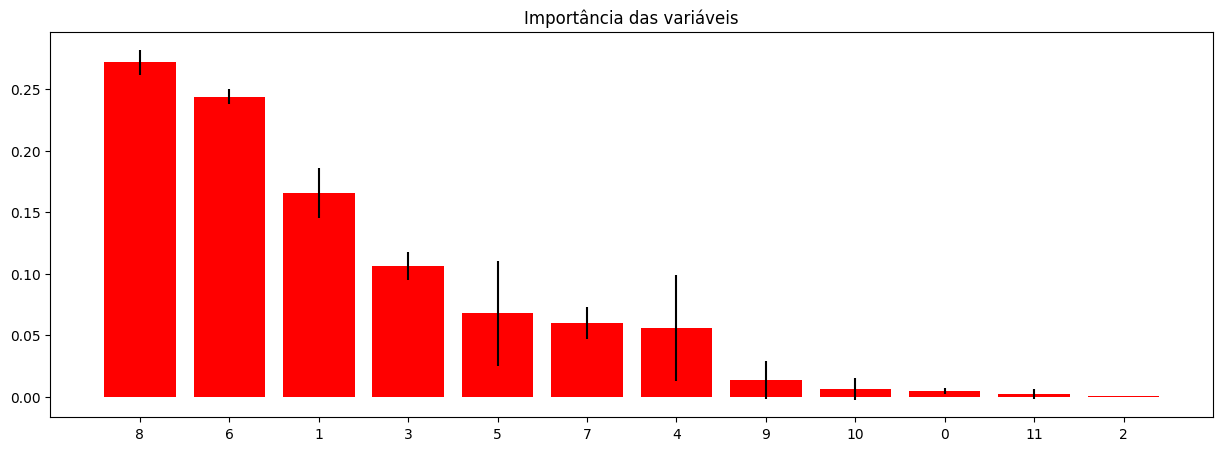

In [55]:
importancias = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importancias)[::-1]

#Imprimindo o rank das importâncias
print('Rank das importâncias:')
df = pd.DataFrame()
for i, j in zip(x_treino_n, forest.feature_importances_):
    aux = pd.DataFrame({'Variavel': i, 'Importancia': j}, index = [0])
    df = pd.concat([df, aux], axis = 0)

print(df.sort_values('Importancia', ascending = False))

#Plotando a impureza baseando-se na importância das variáveis
plt.figure(figsize = (15, 5))
plt.title('Importância das variáveis')
plt.bar(range(x_treino_n.shape[1]), importancias[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_treino_n.shape[1]), indices)
plt.xlim([-1, x_treino_n.shape[1]])
plt.show();

# 7. (Algoritmos de ML) Passo 7: Implementar os modelos de machine learning

In [56]:
df7 = df6.copy()

In [57]:
#Colunas selecionadas a partir a importância das variáveis
colunas_selecionadas_importancia_das_arvores = ['Annual_Premium',
                                                'Vintage',
                                                'Age',
                                                'Region_Code',
                                                'Vehicle_Damage',
                                                'Policy_Sales_Channel',
                                                'Previously_Insured']

colunas_nao_selecionadas = ['Gender',
                            'Driving_License',
                            'Vehicle_Age_below_1_year',
                            'Vehicle_Age_between_1_2_year',
                            'Vehicle_Age_over_2_years']

colunas_adicionadas = ['Gender',
                       'Driving_License'] #Foram adicionadas após verificar que as métricas estavam ruins

colunas_selecionadas = colunas_selecionadas_importancia_das_arvores + colunas_adicionadas

x_treino = df7[colunas_selecionadas]
y_treino = y_treino
x_teste = x_teste[colunas_selecionadas]
y_teste = y_teste

In [58]:
#**************************************** OBSERVAÇÃO IMPORTANTE ****************************************

#Neste problema não estamos querendo encontrar se a pessoa vai comprar ou não, ou seja, estamos querendo 
#criar um score que ordena estas pessoas com maior chance de probabilidade e isso é diferente de dizer qual
#a probabilidade da pessoa comprar ou não.
#Por exemplo: No problema de classifcação tradicional, é pego uma pessoa e diz que ela tem 95% de chance de
#de fazer algo uma compra, neste caso em específico, esta mesma pessoa vai pertencer a uma lista e sua posição
#nesta lista será sua propensão de compra, mesmo as probabilidades sendo as mesmas, estou interessado na
#ordenação da lista. Para este problema de ordenação, não posso utilizar métricas de performance, pois não
#estou interessado em saber o quão bom é o meu modelo é para dizer o a pessoa vai ou não comprar, e sim
#o quão bom ele ordena uma lista, e para isso é necessário utilizar métricas de ordenação

In [59]:
#COM OS DADOS DE VALIDAÇÃO O ALGORITMO MEDE O PODER DE APRENDIZADO
#COM OS DADOS DE TESTE O ALGORITMO MEDE O PODER DE GENERALIZAÇAO

### 7.1 Algoritmo KNN com CV

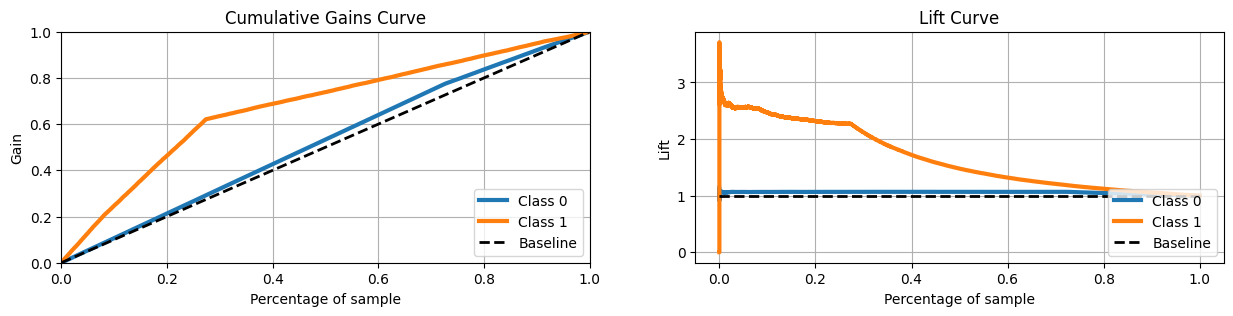

In [60]:
#Definindo o modelo
knn_modelo = nh.KNeighborsClassifier(n_neighbors = 3)

#Treinando o modelo com cross validation
y_pred_knn_cv = cross_val_predict(knn_modelo, x_treino, y_treino, cv = 5, method = 'predict_proba')

#Plotando os gráficos
fig, ax = plt.subplots(ncols = 2, figsize = (15, 3))

#Métrica de ganho acumulado
skplt.metrics.plot_cumulative_gain(y_treino.tolist(), y_pred_knn_cv, ax = ax[0])

#Métrica de ganho em relação a modelos aleatórios
skplt.metrics.plot_lift_curve(y_treino, y_pred_knn_cv, ax = ax[1]);

### 7.2 Algoritmo Regressão logística com CV

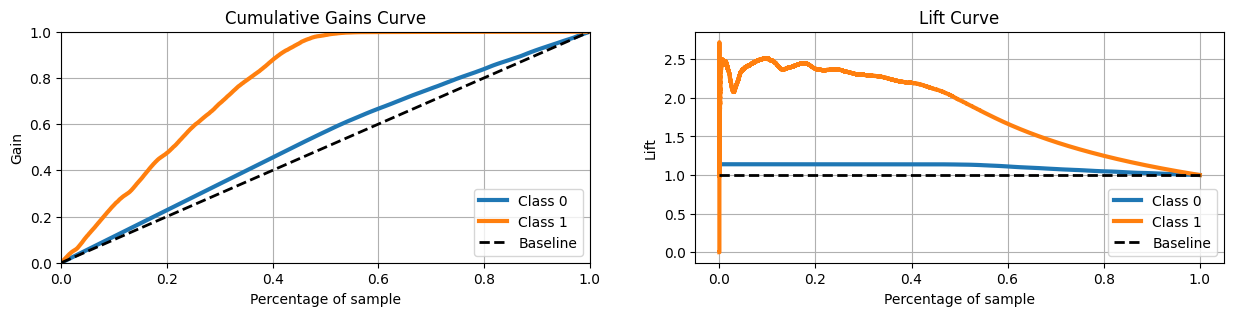

In [61]:
#Definindo o modelo
lr_modelo = lm.LogisticRegression(random_state = 42)

#Treinando o modelo com cross validation
y_pred_lr_cv = cross_val_predict(lr_modelo, x_treino, y_treino, cv = 5, method = 'predict_proba')

#Plotando os gráficos
fig, ax = plt.subplots(ncols = 2, figsize = (15, 3))

#Métrica de ganho acumulado
skplt.metrics.plot_cumulative_gain(y_treino.tolist(), y_pred_lr_cv, ax = ax[0])

#Métrica de ganho em relação a modelos aleatórios
skplt.metrics.plot_lift_curve(y_treino, y_pred_lr_cv, ax = ax[1]);

### 7.3 Algoritmo Extra trees com CV

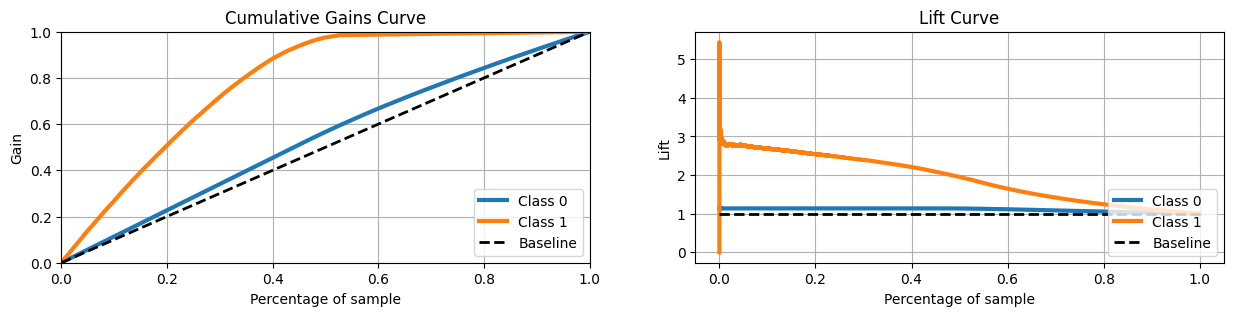

In [62]:
#Definindo o modelo
et_modelo = ExtraTreesClassifier(n_estimators = 130, random_state = 42, n_jobs = -1)

#Treinando o modelo com cross validation
y_pred_et_cv = cross_val_predict(et_modelo, x_treino, y_treino, cv = 5, method = 'predict_proba')

#Plotando os gráficos
fig, ax = plt.subplots(ncols = 2, figsize = (15, 3))

#Métrica de ganho acumulado
skplt.metrics.plot_cumulative_gain(y_treino.tolist(), y_pred_et_cv, ax = ax[0])

#Métrica de ganho em relação a modelos aleatórios
skplt.metrics.plot_lift_curve(y_treino, y_pred_et_cv, ax = ax[1]);

### 7.4 Algoritmo XGboost com CV

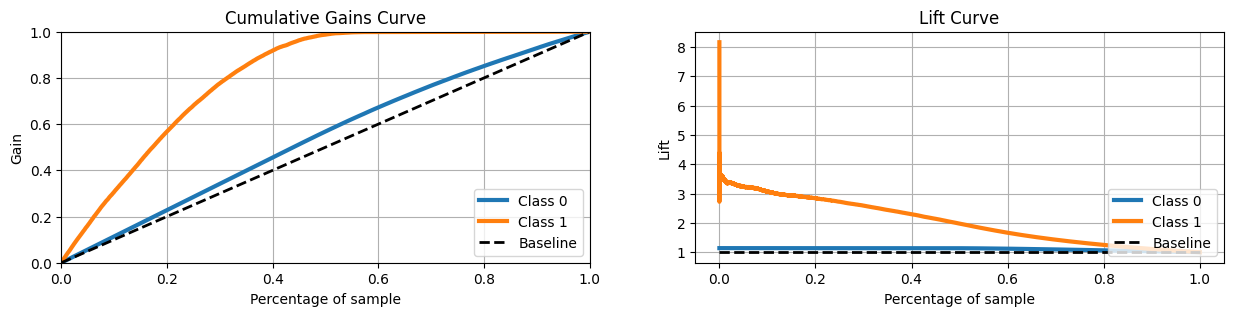

In [63]:
#Definindo o modelo
xgb_modelo = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, max_depth = 3, random_state = 42)

#Treinando o modelo com cross validation
y_pred_xgb_cv = cross_val_predict(xgb_modelo, x_treino, y_treino, cv = 5, method = 'predict_proba')

#Plotando os gráficos
fig, ax = plt.subplots(ncols = 2, figsize = (15, 3))

#Métrica de ganho acumulado
skplt.metrics.plot_cumulative_gain(y_treino.tolist(), y_pred_xgb_cv, ax = ax[0])

#Métrica de ganho em relação a modelos aleatórios
skplt.metrics.plot_lift_curve(y_treino, y_pred_xgb_cv, ax = ax[1]);

### 7.5 Performance dos modelos

#### 7.5.1 Algoritmo KNN

In [66]:
#Inserindo a pontuação (probabilidade) de propensão
df7['Score'] = y_pred_knn_cv[:, 1].tolist()

#Classificando os clientes por pontuação de propensão
df7 = df7.sort_values('Score', ascending = False)

#Computando a precision até k
precision_at_50_knn = round(precision_at_k(df7, k = 50), 5)

#Computando a recall até k
recall_at_50_knn = round(recall_at_k(df7, k = 50), 5)

#### 7.5.2 Algoritmo Regressão linear

In [67]:
#Inserindo a pontuação (probabilidade) de propensão
df7['Score'] = y_pred_lr_cv[:, 1].tolist()

#Classificando os clientes por pontuação de propensão
df7 = df7.sort_values('Score', ascending = False)

#Computando a precision até k
precision_at_50_lr = round(precision_at_k(df7, k = 50), 5)

#Computando a recall até k
recall_at_50_lr = round(recall_at_k(df7, k = 50), 5)

#### 7.5.3 Algoritmo Extra trees

In [68]:
#Inserindo a pontuação (probabilidade) de propensão
df7['Score'] = y_pred_et_cv[:, 1].tolist()

#Classificando os clientes por pontuação de propensão
df7 = df7.sort_values('Score', ascending = False)

#Computando a precision até k
precision_at_50_et = round(precision_at_k(df7, k = 50), 5)

#Computando a recall até k
recall_at_50_et = round(recall_at_k(df7, k = 50), 5)

#### 7.5.4 Algoritmo XGboost

In [69]:
#Inserindo a pontuação (probabilidade) de propensão
df7['Score'] = y_pred_xgb_cv[:, 1].tolist()

#Classificando os clientes por pontuação de propensão
df7 = df7.sort_values('Score', ascending = False)

#Computando a precision até k
precision_at_50_xgb = round(precision_at_k(df7, k = 50), 5)

#Computando a recall até k
recall_at_50_xgb = round(recall_at_k(df7, k = 50), 5)

In [70]:
resumo = pd.DataFrame({'Precision_at_k': [precision_at_50_knn, precision_at_50_lr, precision_at_50_et, precision_at_50_xgb]}, 
                       index = ['KNN', 'Regressão logística', 'Extra trees', 'XGboost']).reset_index()
resumo.columns = ['Algoritmo', 'Precision_at_k']
aux = resumo.sort_values('Precision_at_k', ascending = False).reset_index(drop = True)
aux.style.highlight_max(subset = ['Precision_at_k'], color = 'red')

,Algoritmo,Precision_at_k
0,KNN,0.235290
1,Extra trees,0.156860
2,XGboost,0.078430
3,Regressão logística,0.039220


# 8. (Algoritmos de Ml) Passo 8: Ajuste dos hiperparâmetros no algoritmo

In [71]:
df8 = df7.copy()

### 8.1 Grid search CV

In [72]:
parametros = {'n_estimators': [120, 130, 140],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4],
              'random_state': [42]}

#Definindo o modelo para o ajuste fino
gs_modelo_et = GridSearchCV(estimator = et_modelo, param_grid = parametros)

#Treinando o modelo
gs_modelo_et.fit(x_treino, y_treino)
gs_modelo_et

GridSearchCV(estimator=ExtraTreesClassifier(n_estimators=130, n_jobs=-1,
                                            random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [120, 130, 140],
                         'random_state': [42]})

In [73]:
melhores_parametros = gs_modelo_et.best_params_
melhor_resultado = gs_modelo_et.best_score_
melhores_parametros, melhor_resultado

({'criterion': 'gini',
  'max_depth': 2,
  'n_estimators': 120,
  'random_state': 42},
 0.8774693575347857)

### 8.2 Treinar modelo escolhido com os melhores parâmetros

In [74]:
#Predição do modelo -> COM OS DADOS DE TESTE O ALGORITMO MEDE O PODER DE GENERALIZAÇÃO
y_pred_et = gs_modelo_et.predict_proba(x_teste)

### 8.3 Performance do modelo escolhido com os melhores parâmetros

In [75]:
#Inserindo a pontuação (probabilidade) de propensão
x_teste['Score'] = y_pred_et[:, 1].tolist()

#Classificando os clientes por pontuação de propensão
x_teste = x_teste.sort_values('Score', ascending = False)

#Computando a precision até k
precision_at_50_et_prod = round(precision_at_k(df8, k = 50), 5)

pd.DataFrame({'Precision_at_k': precision_at_50_et_prod}, index = ['Extra trees']).reset_index()

,index,Precision_at_k
0,Extra trees,0.07843


# 9. (Avaliação do algoritmo) Passo 9: Performance do negócio ROI

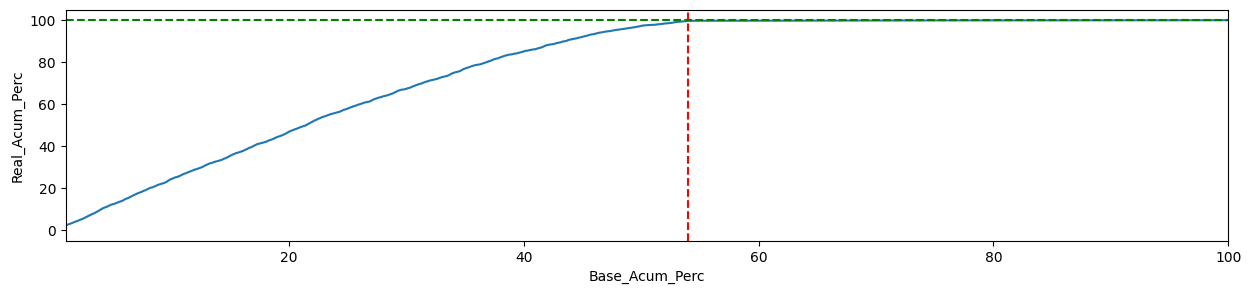

In [76]:
#Criando uma tabela com os dados reais e os dados previstos
resultado = pd.DataFrame()
resultado['Prediction'] = x_teste['Score']
resultado['Real'] = y_teste

#Ordenando os dados previstos do maior para menor
resultado.sort_values('Prediction', ascending = False)

#Criando uma coluna com a soma acumulada e o percentual dos potenciais interessados 
resultado['Real_Acum'] = resultado['Real'].cumsum()
resultado['Real_Acum_Perc'] = 100 * resultado['Real_Acum'] / resultado['Real'].sum()

#Criando uma coluna com a soma acumulada dos dados originais
resultado['Base'] = range(1, len(resultado ) + 1)
resultado['Base_Acum_Perc'] = 100 * resultado['Base'] / len(resultado)

#Criando um gráfico
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

sns.lineplot(x = 'Base_Acum_Perc', y = 'Real_Acum_Perc', data = resultado)
plt.axhline(y = 100, color = 'green', linestyle = '--')
plt.axvline(x = 54, color = 'red', linestyle = '--')
plt.xlim(1, 100);

### 9.1 Com 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45% e 50% da base de clientes

In [82]:
resultado_final = resultado.copy()

resultado_final['Custo'] = 4 * resultado_final['Prediction']
resultado_final['Receita_bruta'] = 40 * resultado_final['Prediction']
resultado_final['Receita'] = resultado_final['Receita_bruta'] - resultado_final['Custo']
resultado_final['Receita_Acum'] = round(resultado_final['Receita'].cumsum(), 3)

resultado_aux_5 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 5, :]
resultado_aux_10 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 10, :]
resultado_aux_15 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 15, :]
resultado_aux_20 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 20, :]
resultado_aux_25 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 25, :]
resultado_aux_30 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 30, :]
resultado_aux_35 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 35, :]
resultado_aux_40 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 40, :]
resultado_aux_45 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 45, :]
resultado_aux_50 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 50, :]
resultado_aux_55 = resultado_final.loc[resultado_final['Base_Acum_Perc'] <= 55, :]

In [83]:
aux = pd.DataFrame({'Receita': [resultado_aux_5.iloc[-1]['Receita_Acum'], 
                                resultado_aux_10.iloc[-1]['Receita_Acum'], 
                                resultado_aux_15.iloc[-1]['Receita_Acum'], 
                                resultado_aux_20.iloc[-1]['Receita_Acum'],
                                resultado_aux_25.iloc[-1]['Receita_Acum'], 
                                resultado_aux_30.iloc[-1]['Receita_Acum'],
                                resultado_aux_35.iloc[-1]['Receita_Acum'], 
                                resultado_aux_40.iloc[-1]['Receita_Acum'],
                                resultado_aux_45.iloc[-1]['Receita_Acum'], 
                                resultado_aux_50.iloc[-1]['Receita_Acum']]}, 
                                index = ['5%_base', 
                                         '10%_base', 
                                         '15%_base', 
                                         '20%_base', 
                                         '25%_base', 
                                         '30%_base', 
                                         '35%_base', 
                                         '40%_base', 
                                         '45%_base', 
                                         '50%_base']).reset_index()
aux.columns = ['Base_Clientes', 'Receita']
aux

,Base_Clientes,Receita
0,5%_base,14125.779
1,10%_base,27935.447
2,15%_base,41212.040
3,20%_base,54165.944
4,25%_base,66856.639
5,30%_base,79309.589
6,35%_base,91530.234
7,40%_base,103320.324
8,45%_base,114630.734
9,50%_base,124636.169


In [ ]:
#resultado['Intervalo'] = resultado['Prediction'].apply(lambda x: 0.9 if x >= 0.90 else 
#                                                    0.8 if (x >= 0.80) & (x <= 0.90) else 
#                                                    0.7 if (x >= 0.70) & (x <= 0.80) else 
#                                                    0.6 if (x >= 0.60) & (x <= 0.70) else 
#                                                    0.5 if (x >= 0.50) & (x <= 0.60) else 
#                                                    0.4 if (x >= 0.40) & (x <= 0.50) else 
#                                                    0.3 if (x >= 0.30) & (x <= 0.40) else 
#                                                    0.2 if (x >= 0.20) & (x <= 0.30) else 
#                                                    0.1 if (x >= 0.10) & (x <= 0.20) else 0.01)
#
#df = resultado[['Prediction', 'Intervalo']].groupby('Intervalo').agg({'min', 'count'}).reset_index()
#df.columns = df.columns.droplevel()
#df.columns = ['Index', 'Clientes', 'Propensity_score']
#
#df['Receita_bruta'] = 40 * df['Clientes'] * df['Propensity_score'] 
#df['Custo'] = 4 * df['Clientes']
#
#df['Base'] = df['Clientes'].sort_values(ascending = True).cumsum() / df['Clientes'].sum()
#df['Receita'] = df['Receita_bruta'] - df['Custo']
#df.sort_values('Index', ascending = False)

# <s>10. (Avaliação dos algoritmos) Passo 10: Tradução e interpretação do erro</s>

# 11. (Modelo em produção) Passo 11: Modelo em produção

#### 11.1 Salvar o modelo treinado de Ml

In [ ]:
pickle.dump(lr_modelo, open('/home/leonardo/projetos_/propensao_de_compra/API/modelo/PA004.pkl', 'wb'))

#### 11.2 Classe do projeto (salvar em arquivo.py)

In [ ]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance:
    def __init__(self):
        #Colocando os caminhos dos arquivos que foram transformados e salvos no Pickle
        self.home_path = '/home/leonardo/projetos_/propensao_de_compra/API/'
        self.Annual_Premium_scaler = pickle.load(open(self.home_path + 'transformacoes/Annual_Premium_scaler.pkl', 'rb'))
        self.Age_scaler = pickle.load(open(self.home_path + 'transformacoes/Age_scaler.pkl', 'rb'))
        self.Vintage_scaler = pickle.load(open(self.home_path + 'transformacoes/Vintage_scaler.pkl', 'rb'))
        self.Gender_scaler = pickle.load(open(self.home_path + 'transformacoes/Gender_scaler.pkl', 'rb'))
        self.Region_Code_scaler = pickle.load(open(self.home_path + 'transformacoes/Region_Code_scaler.pkl', 'rb'))
        self.Policy_Sales_Channel_scaler = pickle.load(open(self.home_path + 'transformacoes/Policy_Sales_Channel_scaler.pkl', 'rb'))

    def engenharia_de_atributos(self, df1):
        #Alterando os dados da coluna 'Vehicle_Age' e 'Vehicle_Damage'
        df1['Vehicle_Age'] = df1['Vehicle_Age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        df1['Vehicle_Damage'] = df1['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        return df1

    def modelagem_dos_dados(self, df5):
        #Annual_Premium
        df5['Annual_Premium'] = self.Annual_Premium_scaler.transform(df5[['Annual_Premium']].values) #Precisa passar um array

        #Age
        df5['Age'] = self.Age_scaler.transform(df5[['Age']].values) #Precisa passar um array

        #Vintage
        df5['Vintage'] = self.Vintage_scaler.transform(df5[['Vintage']].values) #Precisa passar um array

        #Gender -> Target Encoding
        #Target Encoding
        df5.loc[:, 'Gender'] = df5['Gender'].map(self.Gender_scaler)

        #Region_Code -> Target Encoding
        #Target Encoding
        df5.loc[:, 'Region_Code'] = df5['Region_Code'].map(self.Region_Code_scaler)

        #Vehicle_Age -> One Hot Encoding ou Ordinal Encoding
        #One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='Vehicle_Age', columns=['Vehicle_Age'])

        #Policy_Sales_Channel -> Target Encoding ou Frequency Encoding
        #Frequency Encoding
        df5.loc[:, 'Policy_Sales_Channel'] = df5['Policy_Sales_Channel'].map(self.Policy_Sales_Channel_scaler)

        #Colunas selecionadas a partir a importância das variáveis
        colunas_selecionadas = ['Annual_Premium',
                                'Vintage',
                                'Age',
                                'Region_Code',
                                'Vehicle_Damage',
                                'Policy_Sales_Channel',
                                'Previously_Insured']
        return df5[colunas_selecionadas]

    def get_prediction(self, modelo, dados_original, dados_teste):
        #Predição
        pred = modelo.predict_proba(dados_teste)

        #Juntando a predição com os dados originais
        dados_original['Score'] = pred[:, 1].tolist()

        return dados_original.to_json(orient = 'records', date_format = 'iso')

#### 11.3 Criar API Handler (salvar em arquivo.py)

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#Importando classe HealthInsurance do arquivo HealthInsurance.py da pasta rossmann
#from nome_pasta ponto nome_arquivo import nome da classe dentro do arquivo

#Pacote é a pasta onde está o script.py
#Nome do arquivo.py
#Nome da classe que foi criada dentro do arquivo.py
from codigo.healthinsurance import HealthInsurance

#Colocando o caminho do arquivo do modelo treinado que foi salvo no Pickle
path = '/home/leonardo/projetos_/propensao_de_compra/API/'
modelo = pickle.load(open(path + 'modelo/PA004.pkl', 'rb'))

#Instaciando objeto da classe Flask que será a API
app = Flask(__name__)

#Método POST envia alguma coisa
#Método GET pede alguma coisa
#URL barra predict | Neste EndPoint/predict | EndPoint é tudo que vem depois da url principal, por exemplo: Globo.com/.....
@app.route('/predict', methods = ['POST'])
def health_insurance_predict():
    teste_json = request.get_json() #Recebe um arquivo JSON a partir da request

    if teste_json:  #Se o teste_json for diferente de vazio, ou seja, se foi carregado algum dado
        #Verifica se o arquivo passado é um tipo de dicionário e se sim, foi enviado um arquivo com somente uma linha
        if isinstance(teste_json, dict):
            #Cria um dataframe e para isso é necessário indicar no Pandas qual é o nº da linha inicial, nesta caso, 0
            dados_que_vieram_da_producao = pd.DataFrame(teste_json, index=[0])
        else:
            #Se não for é um dicionário, foi enviado um arquivo com mais de uma linha
            dados_que_vieram_da_producao = pd.DataFrame(
                teste_json, columns = teste_json[0].keys())

        #Instanciando a classe do projeto, neste caso, HealthInsurance
        pipeline = HealthInsurance()

        #engenharia_de_atributos
        df5 = pipeline.engenharia_de_atributos(dados_que_vieram_da_producao)

        #modelagem_dos_dados
        df6 = pipeline.modelagem_dos_dados(df5)

        #predição
        df_resposta = pipeline.get_prediction(modelo, dados_que_vieram_da_producao, df6)
        
        return df_resposta
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    #Dizer para endpoint rodar no localhost (rodando na máquina)
    #port = os.environ.get('PORT', 5000)
    #app.run('0.0.0.0', port = port)
    app.run('0.0.0.0')
#172.25.114.131 -> endereço IPv4 pc local
#app.run('0.0.0.0')

#### 11.4 Testando a API

In [ ]:
import requests

#Carregando os dados para teste
df_teste = df_teste_raw

In [ ]:
df_teste = df_teste.sample(5)
df_teste

In [ ]:
#Convertendo o dataframe em formato JSON
import json

data = json.dumps(df_teste.to_dict(orient = 'records'))

In [ ]:
#Chamando a API
url = 'https://health-insurance-ixwn.onrender.com/predict' #Este é o novo endereço a partir da nuvem
#url = 'http://0.0.0.0:5000/predict' #Endpoint -> 0.0.0.0 é a máquina local e :5000 é a porta padrão da biblioteca flask
header = {'Content-type': 'application/json'} #Indica para o API qual tipo de dado ele está recebendo
data = data #Dados
r = requests.post(url, data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
#Ordenando do maior para o menor
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())
d1.sort_values('Score', ascending = False).head()

In [ ]:
#df_teste.to_excel('Teste_Api.xlsx')